## XGboost
Within this notebook, we want to review Multinominal Logistic Regression, and XGBoost. Furthermore, I want to showcase how to tune Hyperparameters in XGBoost using Bayesian Optimization using the `hyperopt` framework. 
The notebook uses the very simple, leightweight Wine dataset available via sklearn API.

## Import libraries

In [2]:
import pandas as pd
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

## Load Data

In [4]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)

# for plutting purposes one-hot encode target var
target_one_hot = pd.get_dummies(data.target)
df = df.join(target_one_hot, how="left")
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,0,1,2
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,1,0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,1,0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,1,0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,1,0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,0,0,1
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,0,0,1
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,0,0,1
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,0,0,1


## Investigate features


From correlation matrix, we can initially conclude following linear correlations (Pearson):
- Class 0 has strongest corrleation with `proline`
- Class 1 has strongest corrleation with `alcocol` (negative correlation)
- Class 2 has strongest corrleation with `od280/od315_of_diluted_wines` (negative correlation)


<Axes: >

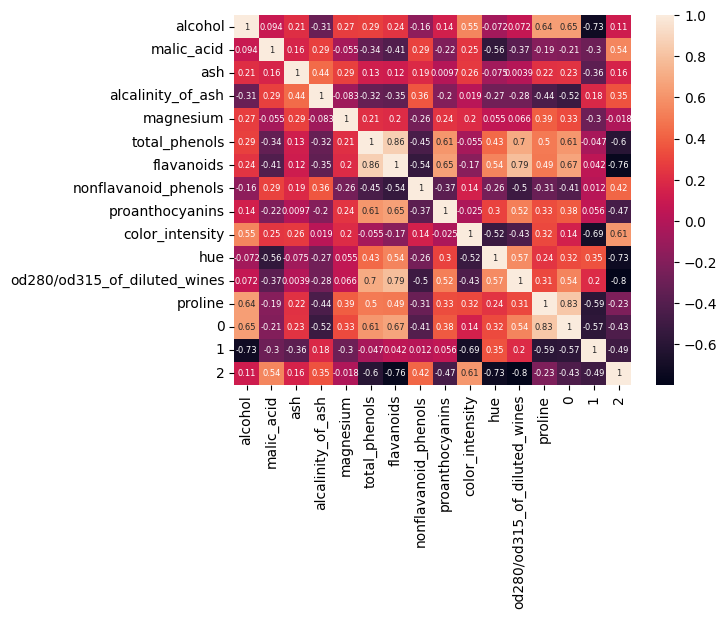

In [5]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize":6})

## Create some boxplots

Get a better understanding of the different features

In [6]:
# Normalize data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(data.data)
df = pd.DataFrame(X_normalized, columns=data.feature_names)
df["target"] = data.target

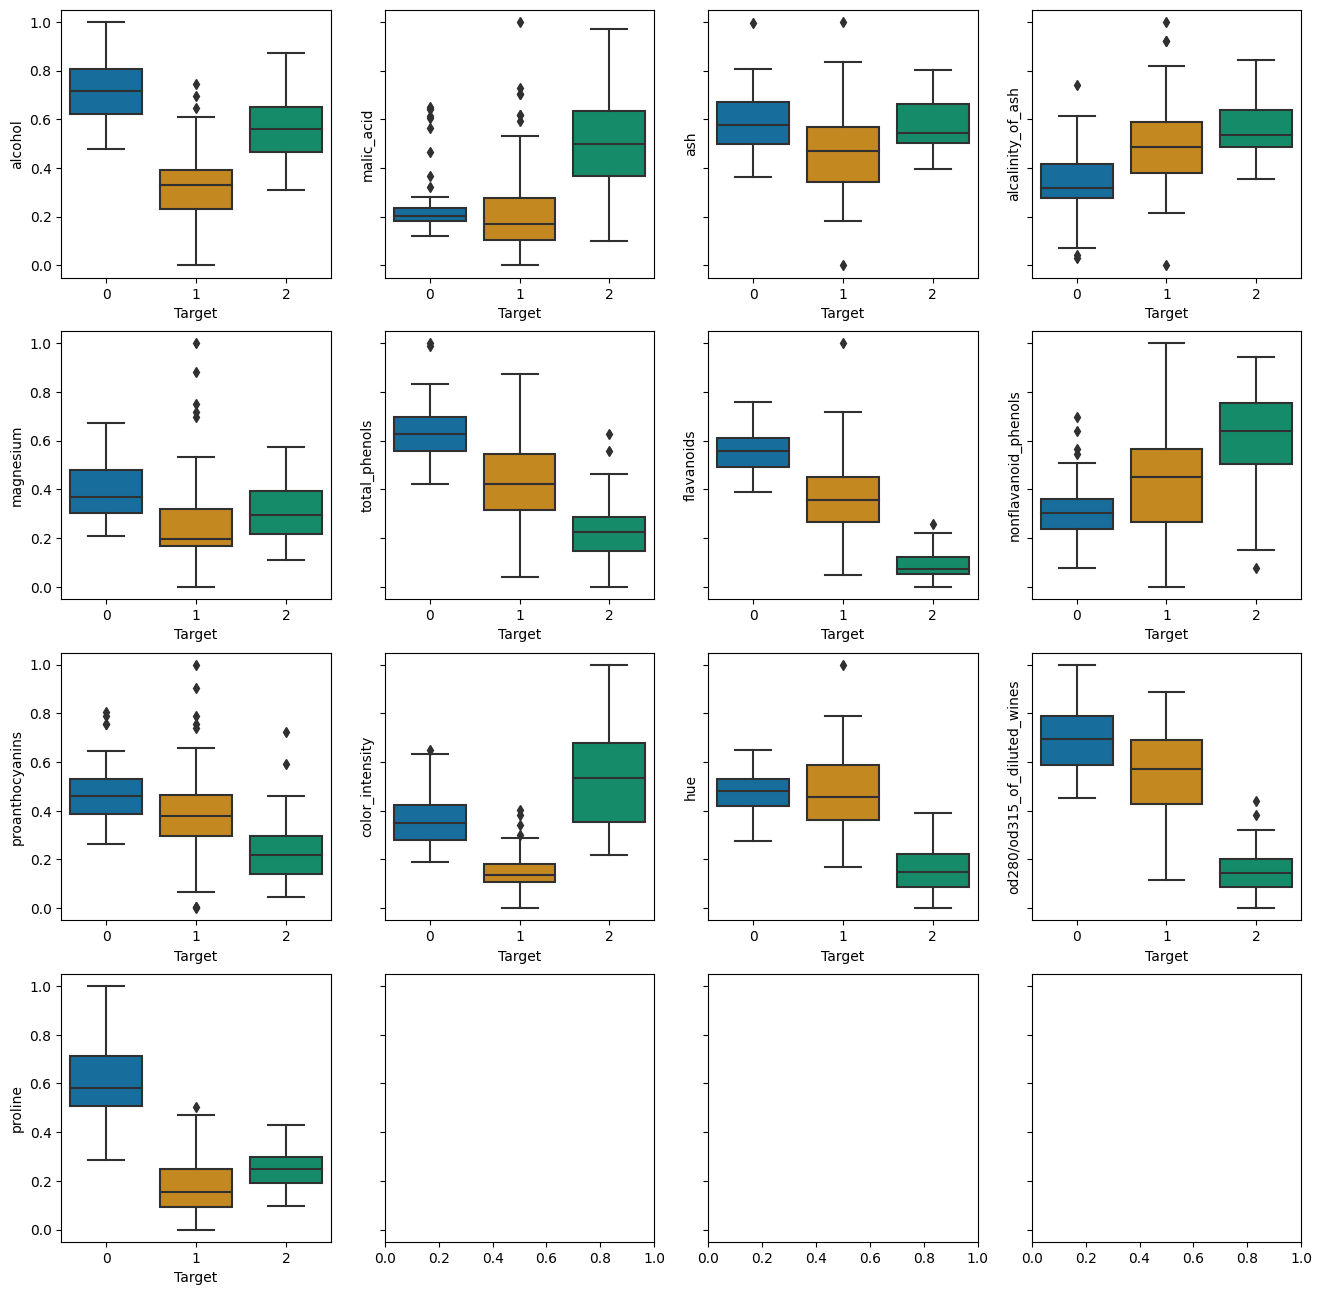

In [7]:
palette = dict(zip([0,1,2], sns.color_palette("colorblind").as_hex()[:3]))

fig, axs = plt.subplots(nrows=4,ncols=4, sharey=True, sharex=False, figsize=(16,16))
for feat, ax in zip(data.feature_names, axs.reshape(-1)): 
    sns.boxplot(x="target", y=feat, data=df, palette=palette, ax=ax)
    ax.set_xlabel("Target")
    ax.set_ylabel(feat)
plt.show()


## Multinominal Logistic Regression


Some mathematical background on multiclass-log-reg:

Let the dataset be given by $\mathcal{D}=\{x_i,y_i\}_{i=1}^N$, with $C$ classes. We model the posterior distribution for $k \in \{1,...,C\}$ as 
$$ \boldsymbol{y}_k \vert \boldsymbol{x} \sim \text{Categorical}\biggl(\frac{\exp(w_k^Tx)}{\sum_{c=1}^C \exp(w_c^Tx)} \biggr),$$

as Categorical distribution, where $p(y=k \vert \boldsymbol{x}) = \frac{\exp(w_k^Tx)}{\sum_{c=1}^C \exp(w_c^Tx)}$ is defined by the Softmax function. As usual, we want to minimize the negative-log-likelihood (NLL). For that let $y$ be one hot encoded, that means for each sample $i$, then $y_i \in \{0,1\}^C$
$$E(\boldsymbol{w}) = -\log p(\boldsymbol{y} \vert \boldsymbol{X}, w)
= - \sum_{i=1}^N \sum_{c=1}^C y_{ic} \log p(y_i=k \vert \boldsymbol{x}_i, \boldsymbol{w})
= - \sum_{i=1}^N \sum_{c=1}^C y_{ic} \frac{\exp(w_c^Tx)}{\sum_{c'=1}^C \exp(w_{c'}^Tx)}, $$ 

yielding the Cross-Entropy loss.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, data.target, test_size=0.2, random_state=42)

In [9]:
clf = LogisticRegression(random_state=0, multi_class="multinomial").fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
print(f"Multinominal Log-Reg Score: {clf.score(X_test, y_test)}")

Multinominal Log-Reg Score: 1.0


## XGBoost

In [10]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='multi:softprob')

# Fit the model to the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [11]:
print(f"XGBoost score (without tuning): {model.score(X_test, y_test)}")

XGBoost score (without tuning): 0.9444444444444444


## Bayesian Hyperparameter optimization XGBoost model

In [12]:
# Define hyperparameter space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 100)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 1),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
    'lambda': hp.loguniform('lambda', -10, 10),
    'eval_metric': 'auc',
    'seed': 123,
    'n_estimators': hp.uniform('n_estimators', 80, 120)
}

In [13]:
def objective(space):
    clf = XGBClassifier(objective='multi:softprob',
                        eval_metric="auc",
                        n_estimators=int(space['n_estimators']), 
                        max_depth=int(space['max_depth']), 
                        learning_rate=space['learning_rate'],
                        subsample=space['subsample'],
                        reg_alpha=int(space['reg_alpha']),
                        min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']),            
                        early_stopping_rounds=10,)
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, 
            y_train,
            eval_set=evaluation, 
            verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(pred, y_test)
    print ("Score:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [14]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)


  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Score:                                                 
0.9722222222222222                                     
Score:                                                 
1.0                                                                               
Score:                                                                            
1.0                                                                
Score:                                                             
0.9444444444444444                                                 
Score:                                                             
1.0                                                                
Score:                                                             
0.9722222222222222                                                 
Score:                                                             
1.0                                                                
Score:                                                

In [15]:
best_hyperparams

{'colsample_bytree': 0.5507483656022707,
 'lambda': 63.60742712686387,
 'learning_rate': 0.0015681805073841353,
 'max_depth': 28.032519640529493,
 'min_child_weight': 7.260156213557299,
 'n_estimators': 115.36745950410796,
 'reg_alpha': 0.8663430367856235,
 'reg_lambda': 0.6274558012132216,
 'subsample': 0.9836494000520737}

In [16]:
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='multi:softprob',
                      n_estimators=int(best_hyperparams['n_estimators']), 
                      max_depth=int(best_hyperparams['max_depth']), 
                      learning_rate=best_hyperparams['learning_rate'],
                      subsample=best_hyperparams['subsample'],
                      reg_alpha=int(best_hyperparams['reg_alpha']),
                      min_child_weight=int(best_hyperparams['min_child_weight']),
                      colsample_bytree=int(best_hyperparams['colsample_bytree']),            
                      )

# Fit the model to the training data
model.fit(X_train, y_train)
print(f"XGBoost score (with tuning): {model.score(X_test, y_test)}")

XGBoost score (with tuning): 1.0


## Conclusion

Obviously, hyperparamaters can have huge impact on the model's performance. Here, the goal was to review XGBoost and how one can use Bayesian Hyperparameter optimization on a very simple task/ dataset.

In [23]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.5.3
seaborn==0.12.2
hyperopt==0.2.7
xgboost==2.0.3
sklearn==1.3.1
matplotlib==3.7.1
